In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import pygame
import copy
import time
import matplotlib.pyplot as plt

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
        self.transition = namedtuple('Transition',
                                   ('state', 'action', 'next_state', 'reward'))
    
    def push(self, *args):
        self.memory.append(self.transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [5]:
class TetrisAgent:
    def __init__(self, state_size, action_size):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        
        self.policy_net = DQN(state_size, action_size).to(self.device)
        self.target_net = DQN(state_size, action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.batch_size = 256
        self.gamma = 0.99
        self.eps_start = 1.0
        self.eps_end = 0.01
        self.eps_decay = 2000
        self.target_update = 5
        self.learning_rate = 0.0001
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(10000)
        self.steps_done = 0  # Added this line
        
    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
                       np.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        
        if sample > eps_threshold:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], 
                              device=self.device, dtype=torch.long)
    
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch = self.memory.transition(*zip(*transitions))
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), 
                                    device=self.device, dtype=torch.bool)
        non_final_next_states = torch.FloatTensor([s for s in batch.next_state
                                                 if s is not None]).to(self.device)
        
        state_batch = torch.FloatTensor(batch.state).to(self.device)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.FloatTensor(batch.reward).to(self.device)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

In [6]:
SHAPES = {
    'I': [[(0,0), (0,1), (0,2), (0,3)],
          [(0,0), (1,0), (2,0), (3,0)]],
    'O': [[(0,0), (0,1), (1,0), (1,1)]],
    'T': [[(0,1), (1,0), (1,1), (1,2)],
          [(0,1), (1,1), (1,2), (2,1)],
          [(1,0), (1,1), (1,2), (2,1)],
          [(0,1), (1,0), (1,1), (2,1)]],
    'L': [[(0,2), (1,0), (1,1), (1,2)],
          [(0,1), (1,1), (2,1), (2,2)],
          [(1,0), (1,1), (1,2), (2,0)],
          [(0,0), (0,1), (1,1), (2,1)]],
}

class TetrisEnv:
    def __init__(self, width=10, height=20):
        self.width = width
        self.height = height
        self.board = None
        self.current_piece = None
        self.current_pos = None
        self.score = 0
        
        self.colors = {
            'I': (0, 255, 255),    # Cyan
            'O': (255, 255, 0),    # Yellow
            'T': (128, 0, 128),    # Purple
            'L': (255, 165, 0),    # Orange
            'grid': (128, 128, 128) # Gray
        }
        
        self.reset()
    
    def _get_max_height(self):
        for y in range(self.height):
            if 1 in self.board[y]:
                return self.height - y
        return 0

    def _count_holes(self):
        holes = 0
        for col in range(self.width):
            block_found = False
            for row in range(self.height):
                if self.board[row][col] == 1:
                    block_found = True
                elif block_found and self.board[row][col] == 0:
                    holes += 1
        return holes
    
    def reset(self):
        self.board = np.zeros((self.height, self.width), dtype=int)
        self.spawn_piece()
        return self._get_state()
    
    def spawn_piece(self):
        self.current_piece = random.choice(list(SHAPES.keys()))
        self.current_rotation = 0
        self.current_pos = [0, self.width // 2 - 1]
    
    def _get_current_shape(self):
        return SHAPES[self.current_piece][self.current_rotation]
    
    def _is_valid_move(self, pos, shape):
        for block in shape:
            y = pos[0] + block[0]
            x = pos[1] + block[1]
            if (x < 0 or x >= self.width or 
                y >= self.height or 
                (y >= 0 and self.board[y][x])):
                return False
        return True
    
    def _clear_lines(self):
        lines_cleared = 0
        y = self.height - 1
        while y >= 0:
            if np.all(self.board[y]):
                self.board = np.vstack((np.zeros((1, self.width)), 
                                      self.board[:y], 
                                      self.board[y+1:]))
                lines_cleared += 1
            else:
                y -= 1
        return lines_cleared
    
    def _get_state(self):
        board_state = self.board.flatten()
        piece_state = np.zeros(len(SHAPES))
        piece_state[list(SHAPES.keys()).index(self.current_piece)] = 1
        heights = np.array([self._get_column_height(col) for col in range(self.width)])
        holes = np.array([self._get_column_holes(col) for col in range(self.width)])
        bumpiness = np.diff(heights)
        
        return np.concatenate([
            board_state,
            piece_state,
            heights / self.height,
            holes / self.height,
            bumpiness / self.height
        ])
    
    def _get_column_height(self, col):
        for row in range(self.height):
            if self.board[row][col] == 1:
                return self.height - row
        return 0
    
    def _get_column_holes(self, col):
        holes = 0
        block_found = False
        for row in range(self.height):
            if self.board[row][col] == 1:
                block_found = True
            elif block_found and self.board[row][col] == 0:
                holes += 1
        return holes
    
    def step(self, action):
        reward = 0
        done = False
        initial_height = self._get_max_height()
        
        if action == 0:  # Move left
            new_pos = [self.current_pos[0], self.current_pos[1] - 1]
            if self._is_valid_move(new_pos, self._get_current_shape()):
                self.current_pos = new_pos
                
        elif action == 1:  # Move right
            new_pos = [self.current_pos[0], self.current_pos[1] + 1]
            if self._is_valid_move(new_pos, self._get_current_shape()):
                self.current_pos = new_pos
                
        elif action == 2:  # Rotate
            new_rotation = (self.current_rotation + 1) % len(SHAPES[self.current_piece])
            new_shape = SHAPES[self.current_piece][new_rotation]
            if self._is_valid_move(self.current_pos, new_shape):
                self.current_rotation = new_rotation
        
        # Always try to move down
        new_pos = [self.current_pos[0] + 1, self.current_pos[1]]
        if self._is_valid_move(new_pos, self._get_current_shape()):
            self.current_pos = new_pos
        else:
            # Place the piece
            for block in self._get_current_shape():
                y = self.current_pos[0] + block[0]
                x = self.current_pos[1] + block[1]
                if y >= 0:
                    self.board[y][x] = 1
            
            # Reward for piece placement
            reward += 1
            
            # Extra reward for clearing lines
            lines_cleared = self._clear_lines()
            if lines_cleared > 0:
                reward += (lines_cleared ** 2) * 10
            
            # Penalty for increasing height
            new_height = self._get_max_height()
            if new_height > initial_height:
                reward -= (new_height - initial_height) * 2
            
            # Penalty for holes
            holes = self._count_holes()
            reward -= holes * 1.5
            
            # Spawn new piece
            self.spawn_piece()
            if not self._is_valid_move(self.current_pos, self._get_current_shape()):
                done = True
                reward -= 30
        
        return self._get_state(), reward, done

In [7]:
class TetrisVisualizer:
    def __init__(self, env, cell_size=30):
        pygame.init()
        self.env = env
        self.cell_size = cell_size
        self.width = env.width * cell_size
        self.height = env.height * cell_size
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption('Tetris AI')
        
        self.placed_block_color = (0, 255, 255)  # Cyan
        
    def draw_board(self):
        self.screen.fill((0, 0, 0))
        
        # Draw the grid
        for y in range(self.env.height):
            for x in range(self.env.width):
                pygame.draw.rect(self.screen, self.env.colors['grid'],
                               [x * self.cell_size, y * self.cell_size,
                                self.cell_size, self.cell_size], 1)
        
        # Draw the placed pieces
        for y in range(self.env.height):
            for x in range(self.env.width):
                if self.env.board[y][x]:
                    pygame.draw.rect(self.screen, self.placed_block_color,
                                   [x * self.cell_size, y * self.cell_size,
                                    self.cell_size, self.cell_size])
        
        # Draw the current piece
        if self.env.current_piece:
            piece_color = self.env.colors.get(self.env.current_piece, (255, 255, 255))
            for block in self.env._get_current_shape():
                x = (self.env.current_pos[1] + block[1]) * self.cell_size
                y = (self.env.current_pos[0] + block[0]) * self.cell_size
                if self.env.current_pos[0] + block[0] >= 0:
                    pygame.draw.rect(self.screen, piece_color,
                                   [x, y, self.cell_size, self.cell_size])
        
        pygame.display.flip()
    
    def close(self):
        pygame.quit()

In [8]:
def train_with_visualization(num_episodes=1000):
    env = TetrisEnv()
    visualizer = TetrisVisualizer(env)
    state_size = 200 + len(SHAPES) + env.width * 2 + (env.width - 1)  # Updated state size
    action_size = 4
    
    agent = TetrisAgent(state_size, action_size)
    scores = []
    
    try:
        for episode in range(num_episodes):
            state = env.reset()
            episode_score = 0
            done = False
            
            # Play one episode
            while not done:
                # Select and perform an action
                action = agent.select_action(state)
                next_state, reward, done = env.step(action.item())
                episode_score += reward
                
                # Store the transition in memory
                agent.memory.push(state, action, next_state, reward)
                
                # Move to the next state
                state = next_state
                
                # Perform one step of optimization
                agent.optimize_model()
                
                # Visualize every 10th episode
                if episode % 10 == 0:
                    visualizer.draw_board()
                    pygame.event.pump()  # Handle pygame events
                    time.sleep(0.05)  # Add small delay for visualization
            
            # Update the target network every few episodes
            if episode % agent.target_update == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
            
            scores.append(episode_score)
            
            # Print progress every 10 episodes
            if episode % 10 == 0:
                avg_score = np.mean(scores[-10:]) if len(scores) >= 10 else np.mean(scores)
                print(f'Episode {episode}/{num_episodes}, Average Score: {avg_score:.2f}')
                
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    finally:
        visualizer.close()
    
    return scores

def evaluate_agent(agent, num_episodes=10, visualize=True):
    env = TetrisEnv()
    visualizer = TetrisVisualizer(env) if visualize else None
    scores = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_score = 0
        done = False
        
        while not done:
            # Select action without exploration
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                action = agent.policy_net(state_tensor).max(1)[1].view(1, 1)
            
            # Perform action
            next_state, reward, done = env.step(action.item())
            episode_score += reward
            state = next_state
            
            # Visualize if requested
            if visualize:
                visualizer.draw_board()
                pygame.event.pump()
                time.sleep(0.1)
        
        scores.append(episode_score)
        print(f'Evaluation Episode {episode + 1}/{num_episodes}, Score: {episode_score:.2f}')
    
    if visualize:
        visualizer.close()
    
    return scores

# Function to run the training and evaluation
def run_tetris_training(training_episodes=1000, eval_episodes=5):
    # Train the agent
    print("Starting training...")
    training_scores = train_with_visualization(num_episodes=training_episodes)
    
    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(training_scores)
    plt.title('Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()
    
    # Evaluate the trained agent
    print("\nEvaluating trained agent...")
    env = TetrisEnv()
    state_size = 200 + len(SHAPES) + env.width * 2 + (env.width - 1)
    action_size = 4
    agent = TetrisAgent(state_size, action_size)
    eval_scores = evaluate_agent(agent, num_episodes=eval_episodes)
    
    print(f"\nEvaluation Results:")
    print(f"Average Score: {np.mean(eval_scores):.2f}")
    print(f"Best Score: {np.max(eval_scores):.2f}")
    
    return training_scores, eval_scores

Starting training...
Episode 0/1000, Average Score: -1005.50


C:\Users\Hrishi\AppData\Local\Temp\ipykernel_29568\1141723450.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  non_final_next_states = torch.FloatTensor([s for s in batch.next_state


Episode 10/1000, Average Score: -575.45
Episode 20/1000, Average Score: -865.50
Episode 30/1000, Average Score: -687.05
Episode 40/1000, Average Score: -785.55
Episode 50/1000, Average Score: -894.80
Episode 60/1000, Average Score: -1005.10
Episode 70/1000, Average Score: -962.75
Episode 80/1000, Average Score: -936.45
Episode 90/1000, Average Score: -950.00
Episode 100/1000, Average Score: -740.80
Episode 110/1000, Average Score: -723.45
Episode 120/1000, Average Score: -1066.60
Episode 130/1000, Average Score: -971.45
Episode 140/1000, Average Score: -831.40
Episode 150/1000, Average Score: -1156.15
Episode 160/1000, Average Score: -941.25
Episode 170/1000, Average Score: -1207.70
Episode 180/1000, Average Score: -1186.10
Episode 190/1000, Average Score: -1160.65
Episode 200/1000, Average Score: -1099.10
Episode 210/1000, Average Score: -825.55
Episode 220/1000, Average Score: -996.95
Episode 230/1000, Average Score: -857.25
Episode 240/1000, Average Score: -1079.00
Episode 250/1000,

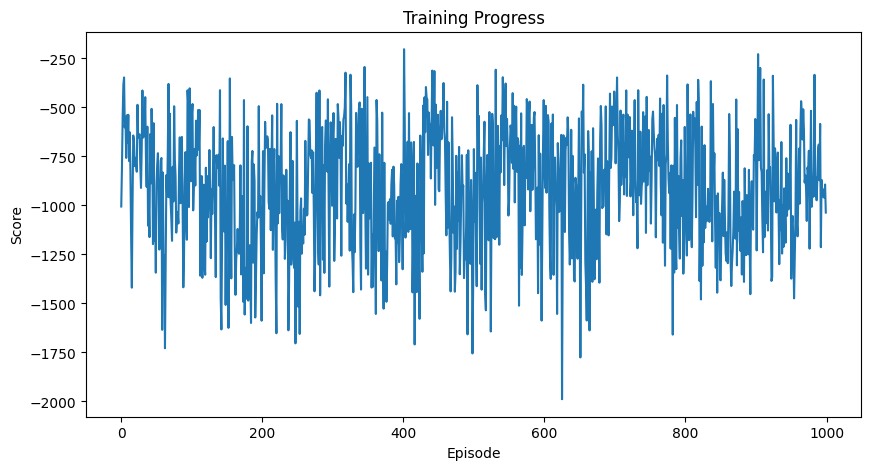


Evaluating trained agent...
Evaluation Episode 1/5, Score: -271.00
Evaluation Episode 2/5, Score: -189.00
Evaluation Episode 3/5, Score: -343.50
Evaluation Episode 4/5, Score: -253.00
Evaluation Episode 5/5, Score: -336.00

Evaluation Results:
Average Score: -278.50
Best Score: -189.00


In [9]:
training_scores, eval_scores = run_tetris_training(training_episodes=1000, eval_episodes=5)